### Importações

In [ ]:
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Importações de ML
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ( f1_score, accuracy_score, classification_report, fbeta_score, make_scorer, precision_score, recall_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, brier_score_loss )
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Importações de Reamostragem
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

### Carregar Datasets e Output

In [ ]:
output_path = 'CardiopatiaModel/'

datasets = {
    "Base": pd.read_csv('CardiopatiaModel/Data/risco_cardiovascular_base.csv'),
    "Features": pd.read_csv('CardiopatiaModel/Data/risco_cardiovascular_features.csv')
}

### Definição de Modelos e Hiperparâmetros para GridSearch

In [9]:
'''
Aqui criamos o grid de todos modelos com seus respectivos hiperparametros que
vão ser combinados no gridsearch para acharmos a melhor configuração.

Com a pipeline do imblearn tambem é possivel adicionar resampler ou qualquer
pré-processamento pro grid

'''
resampler = [
    SMOTE(random_state=42),
    RandomOverSampler(random_state=42),
    RandomUnderSampler(random_state=42),
    'passthrough'
]

models_config = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'resampler': resampler,
            'classifier__n_estimators': [50, 100, 200],
            'classifier__max_depth': [None, 5, 10],
            'classifier__min_samples_split': [2, 5]
        }
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'resampler': resampler,
            'classifier__max_depth': [None, 3, 5, 10],
            'classifier__criterion': ['gini', 'entropy'],
            'classifier__min_samples_leaf': [1, 2, 4]
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'resampler': resampler,
            'classifier__n_neighbors': [3, 5, 7, 9],
            'classifier__weights': ['uniform', 'distance'],
            'classifier__metric': ['euclidean', 'manhattan']
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'params': {
            'resampler': resampler,
            'classifier__C': [0.1, 1.0, 10.0],
            'classifier__solver': ['lbfgs', 'liblinear']
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='mlogloss'),
        'params': {
            'resampler': resampler,
            'classifier__n_estimators': [50, 100],
            'classifier__learning_rate': [0.01, 0.1],
            'classifier__max_depth': [None, 3, 5]
        }
    },
    'SVM': {
        'model': SVC(random_state=42, probability=True),
        'params': {
            'resampler': resampler,
            'classifier__C': [0.1, 1, 10],
            'classifier__kernel': ['linear', 'rbf'],
            'classifier__gamma': ['scale', 'auto']
        }
    }
}

### Loop de Treinamento

In [11]:
model_save_path = os.path.join(output_path, 'models')
metrics_save_path = os.path.join(output_path, 'metrics')
plot_save_path = os.path.join(output_path, 'plots')
os.makedirs(model_save_path, exist_ok=True)
os.makedirs(metrics_save_path, exist_ok=True)
os.makedirs(plot_save_path, exist_ok=True)

results_list = []

f2_scorer = make_scorer(fbeta_score, beta=2, average='macro', pos_label=None)

for ds_name, df in datasets.items():
    print(f"\n>>> Processando Dataset: {ds_name}")

    # Separar X e y
    X = df.drop('BP_Category', axis=1)
    y = df['BP_Category']

    le = LabelEncoder()
    y = le.fit_transform(y)

    bmi_order = ["Underweight", "Normal Weight", "Overweight", "Obese"]

    # Identificar colunas
    cat_cols = X.copy().drop('BMI Category', axis=1).select_dtypes(include=['object']).columns.tolist()
    num_cols = X.select_dtypes(exclude=['object']).columns.tolist()

    # Preprocessor
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ("ordinal", OrdinalEncoder(categories=[bmi_order]), ['BMI Category']),
    ])

    # Split Treino/Teste (80/20)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    for model_name, config in models_config.items():

        model_filename = f"{model_name}_{ds_name}.pkl"
        metrics_filename = f"{model_name}_{ds_name}_metrics.csv"

        full_model_path = os.path.join(model_save_path, model_filename)
        full_metrics_path = os.path.join(metrics_save_path, metrics_filename)

        # --- Verificar se modelo ja foi treinado ---
        if os.path.exists(full_model_path) and os.path.exists(full_metrics_path):
            print(f"--- Modelo {model_name} já existe para Dataset {ds_name}. Carregando Resultados e Pulando treinamento... ---")
            saved_metrics = pd.read_csv(full_metrics_path)
            results_list.append(saved_metrics.to_dict(orient='records')[0])
            continue

        print(f"\n--- Iniciando GridSearch para {model_name} ---")

        # Pipeline base com placeholder para o resampler
        pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('resampler', SMOTE()), # Placeholder que será substituído pelo Grid
            ('classifier', config['model'])
        ])

        # Cross-Validation (10 Folds para dataset pequeno)
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

        # Grid Search
        grid = GridSearchCV(
            pipeline,
            config['params'],
            cv=cv,
            scoring={'f2_macro': f2_scorer, 'f1_macro': 'f1_macro', 'accuracy': 'accuracy'},
            refit='f2_macro',
            return_train_score=True,
            n_jobs=-1,
            verbose=1,
            error_score='raise'
        )

        grid.fit(X_train, y_train)

        cv_res = pd.DataFrame(grid.cv_results_)

        # Métricas de Treino (do melhor modelo)
        best_idx = grid.best_index_
        train_f2 = cv_res.loc[best_idx, 'mean_train_f2_macro']
        train_f1 = cv_res.loc[best_idx, 'mean_train_f1_macro']
        train_acc = cv_res.loc[best_idx, 'mean_train_accuracy']

        # Métricas de Teste
        y_pred = grid.predict(X_test)
        y_proba = grid.predict_proba(X_test) # Necessário para AUC e Calibração
        test_f2 = fbeta_score(y_test, y_pred, beta=2, average='macro')
        test_f1 = f1_score(y_test, y_pred, average='macro')
        test_acc = accuracy_score(y_test, y_pred)
        test_precision = precision_score(y_test, y_pred, average='macro')
        test_recall = recall_score(y_test, y_pred, average='macro')

        # AUC-ROC
        test_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')

        # Métrica de Calibração (Brier Score)
        # Como Brier é binário, calculamos a média para todas as classes (macro)
        brier_scores = []
        for i in range(len(le.classes_)):
            y_true_bin = (y_test == i).astype(int)
            brier_scores.append(brier_score_loss(y_true_bin, y_proba[:, i]))
        test_brier = np.mean(brier_scores)

        # --- Matriz de Confusão (Visualização e Salvamento)---
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=le.classes_, yticklabels=le.classes_)
        plt.title(f'Matriz de Confusão: {model_name} - {ds_name}')
        plt.ylabel('Real')
        plt.xlabel('Predito')

        # Salva a imagem da matriz
        plot_filename = f"matriz_{model_name}_{ds_name}.png"
        plt.savefig(os.path.join(plot_save_path, plot_filename))
        plt.close() # Fecha a figura para não sobrecarregar a memória

        # ------------------------------------------------------

        current_results = {
            'Model': model_name,
            'Dataset': ds_name,
            'Best_Params': str(grid.best_params_),
            'Train_F2_Macro': train_f2,
            'Train_F1_Macro': train_f1,
            'Train_Accuracy': train_acc,
            'Test_F2_Macro': test_f2,
            'Test_F1_Macro': test_f1,
            'Test_Accuracy': test_acc,
            'Test_Precision': test_precision,
            'Test_Recall': test_recall,
            'Test_AUC_ROC': test_auc,
            'Test_Brier_Score': test_brier
        }

        # Salvar Modelo e Métricas no Drive
        joblib.dump(grid.best_estimator_, full_model_path)
        pd.DataFrame([current_results]).to_csv(full_metrics_path, index=False)

        # No results_list.append, adicione:
        results_list.append(current_results)
        print(f"--- Modelo e métricas de {model_name} salvos! ---")


>>> Processando Dataset: Base
--- Modelo RandomForest já existe para Dataset Base. Carregando Resultados e Pulando treinamento... ---
--- Modelo DecisionTree já existe para Dataset Base. Carregando Resultados e Pulando treinamento... ---
--- Modelo KNN já existe para Dataset Base. Carregando Resultados e Pulando treinamento... ---
--- Modelo LogisticRegression já existe para Dataset Base. Carregando Resultados e Pulando treinamento... ---
--- Modelo XGBoost já existe para Dataset Base. Carregando Resultados e Pulando treinamento... ---
--- Modelo SVM já existe para Dataset Base. Carregando Resultados e Pulando treinamento... ---

>>> Processando Dataset: Features

--- Iniciando GridSearch para RandomForest ---
Fitting 10 folds for each of 72 candidates, totalling 720 fits
--- Modelo e métricas de RandomForest salvos! ---

--- Iniciando GridSearch para DecisionTree ---
Fitting 10 folds for each of 96 candidates, totalling 960 fits
--- Modelo e métricas de DecisionTree salvos! ---

--- 

### Resultados

In [12]:
df_results = pd.DataFrame(results_list)

# Criar tabelas separadas por modelo
for model_name in models_config.keys():
    df_model = df_results[df_results['Model'] == model_name].copy()

    print(f"\n--- Tabela Final: {model_name} ---")
    display(df_model[['Dataset', 'Train_F2_Macro', 'Train_Accuracy', 'Test_F2_Macro', 'Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_AUC_ROC', 'Test_Brier_Score', 'Best_Params']])

print(f"\nProcesso concluído! Os arquivos foram salvos em: {output_path}")


--- Tabela Final: RandomForest ---


,Dataset,Train_F2_Macro,Train_Accuracy,Test_F2_Macro,Test_Accuracy,Test_Precision,Test_Recall,Test_AUC_ROC,Test_Brier_Score,Best_Params
0,Base,0.998442,0.998141,0.954724,0.946667,0.944127,0.959596,1.000000,0.029197,"{'classifier__max_depth': 5, 'classifier__min_..."
6,Features,0.985700,0.983278,0.977688,0.973333,0.972222,0.979798,0.997563,0.019602,"{'classifier__max_depth': 5, 'classifier__min_..."



--- Tabela Final: DecisionTree ---


,Dataset,Train_F2_Macro,Train_Accuracy,Test_F2_Macro,Test_Accuracy,Test_Precision,Test_Recall,Test_AUC_ROC,Test_Brier_Score,Best_Params
1,Base,1.0,1.0,0.961699,0.960000,0.956522,0.964646,0.973232,0.026667,"{'classifier__criterion': 'entropy', 'classifi..."
7,Features,1.0,1.0,0.974366,0.973333,0.974026,0.974747,0.980375,0.017778,"{'classifier__criterion': 'gini', 'classifier_..."



--- Tabela Final: KNN ---


,Dataset,Train_F2_Macro,Train_Accuracy,Test_F2_Macro,Test_Accuracy,Test_Precision,Test_Recall,Test_AUC_ROC,Test_Brier_Score,Best_Params
2,Base,1.0,1.0,0.966459,0.960000,0.960000,0.969697,1.000000,0.018384,"{'classifier__metric': 'manhattan', 'classifie..."
8,Features,1.0,1.0,0.977688,0.973333,0.972222,0.979798,0.991399,0.014781,"{'classifier__metric': 'manhattan', 'classifie..."



--- Tabela Final: LogisticRegression ---


,Dataset,Train_F2_Macro,Train_Accuracy,Test_F2_Macro,Test_Accuracy,Test_Precision,Test_Recall,Test_AUC_ROC,Test_Brier_Score,Best_Params
3,Base,0.995250,0.994797,0.925237,0.92,0.924786,0.927778,0.988459,0.036103,"{'classifier__C': 10.0, 'classifier__solver': ..."
9,Features,0.997198,0.996656,0.966459,0.96,0.960000,0.969697,0.996991,0.022929,"{'classifier__C': 10.0, 'classifier__solver': ..."



--- Tabela Final: XGBoost ---


,Dataset,Train_F2_Macro,Train_Accuracy,Test_F2_Macro,Test_Accuracy,Test_Precision,Test_Recall,Test_AUC_ROC,Test_Brier_Score,Best_Params
4,Base,1.0,1.0,0.977337,0.973333,0.969634,0.979798,0.999759,0.013998,"{'classifier__learning_rate': 0.1, 'classifier..."
10,Features,1.0,1.0,0.988570,0.986667,0.984127,0.989899,1.000000,0.006152,"{'classifier__learning_rate': 0.1, 'classifier..."



--- Tabela Final: SVM ---


,Dataset,Train_F2_Macro,Train_Accuracy,Test_F2_Macro,Test_Accuracy,Test_Precision,Test_Recall,Test_AUC_ROC,Test_Brier_Score,Best_Params
5,Base,0.997509,0.997026,0.988867,0.986667,0.985507,0.989899,1.0,0.007127,"{'classifier__C': 10, 'classifier__gamma': 'au..."
11,Features,0.995951,0.995169,0.988867,0.986667,0.985507,0.989899,1.0,0.006098,"{'classifier__C': 10, 'classifier__gamma': 'au..."



Processo concluído! Os arquivos foram salvos em: /content/drive/MyDrive/Ps_Ligia_Time_16/


### Matrizes de Confusão

Encontradas 12 matrizes. Exibindo resultados:



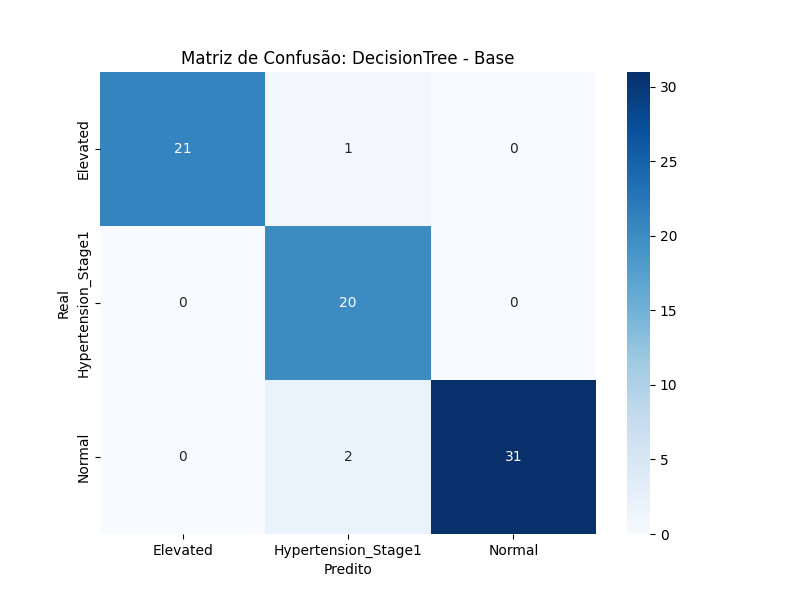

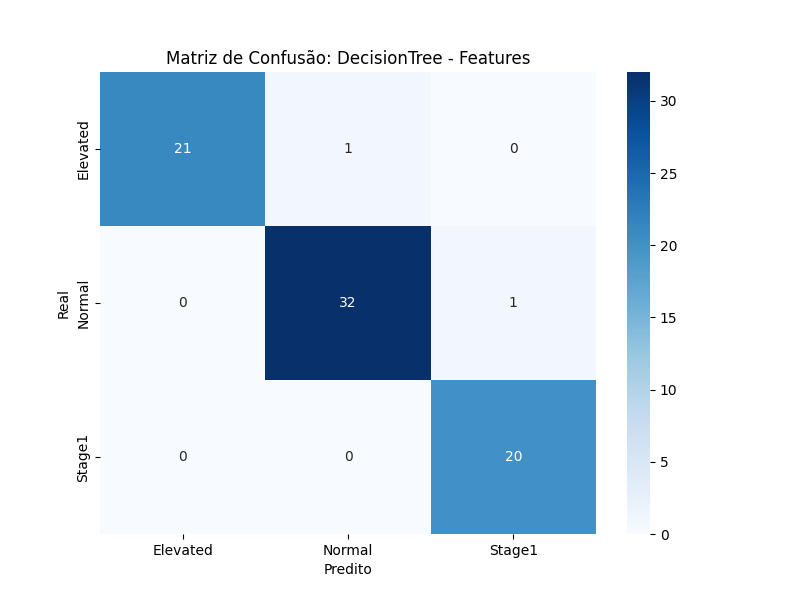

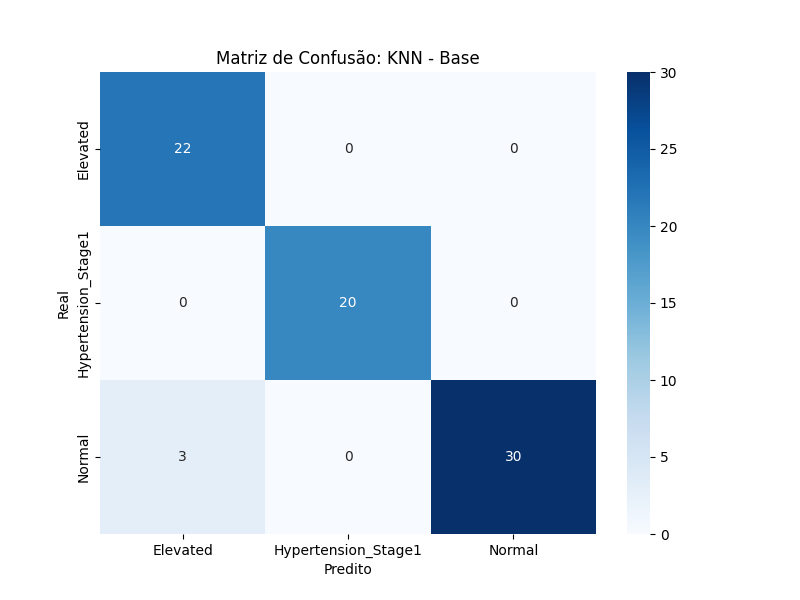

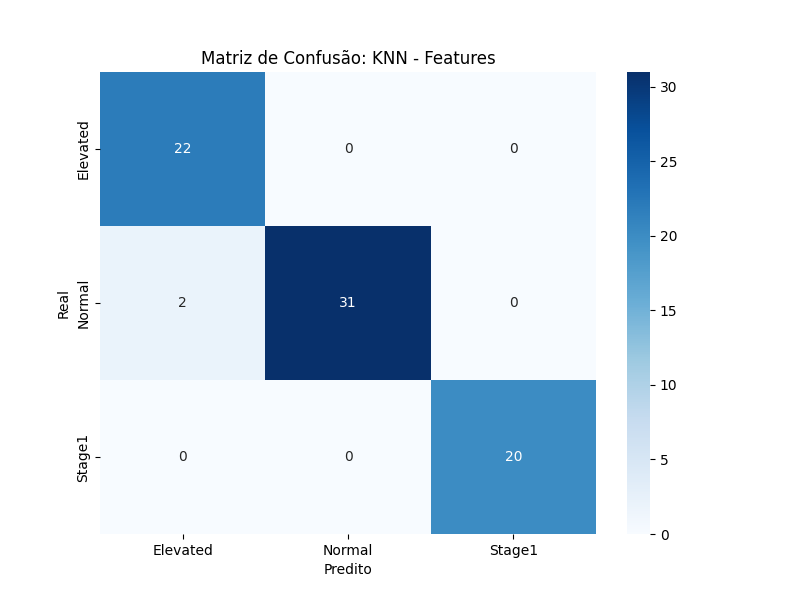

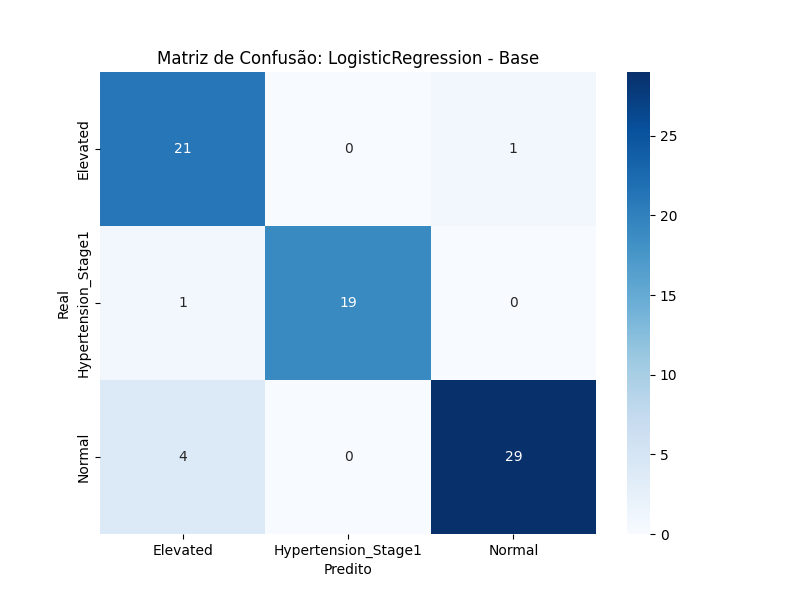

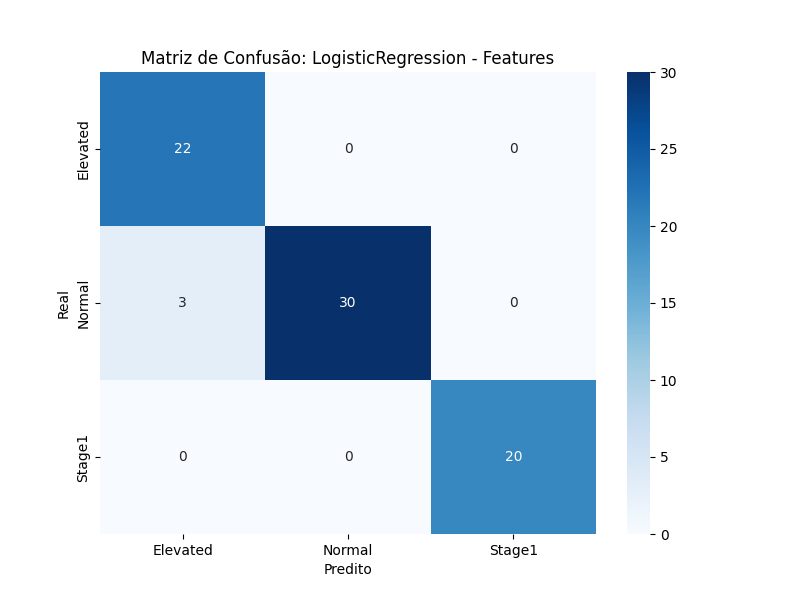

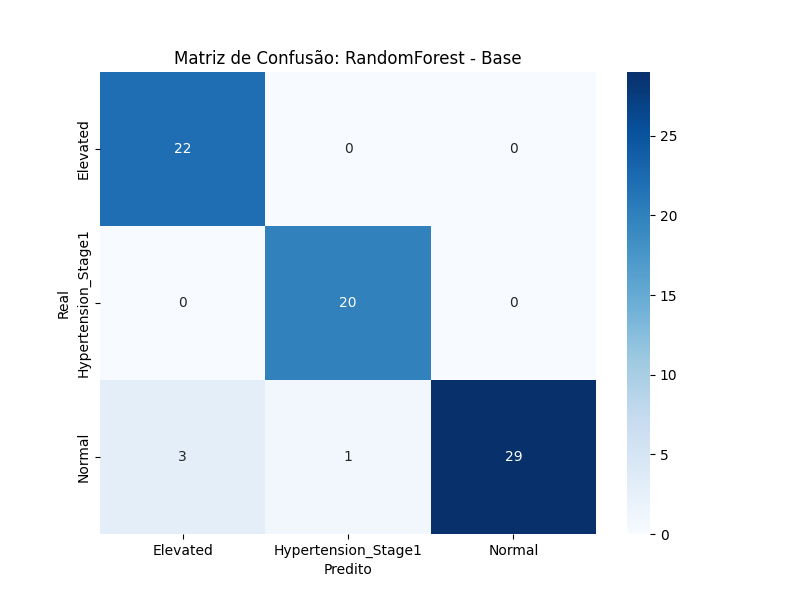

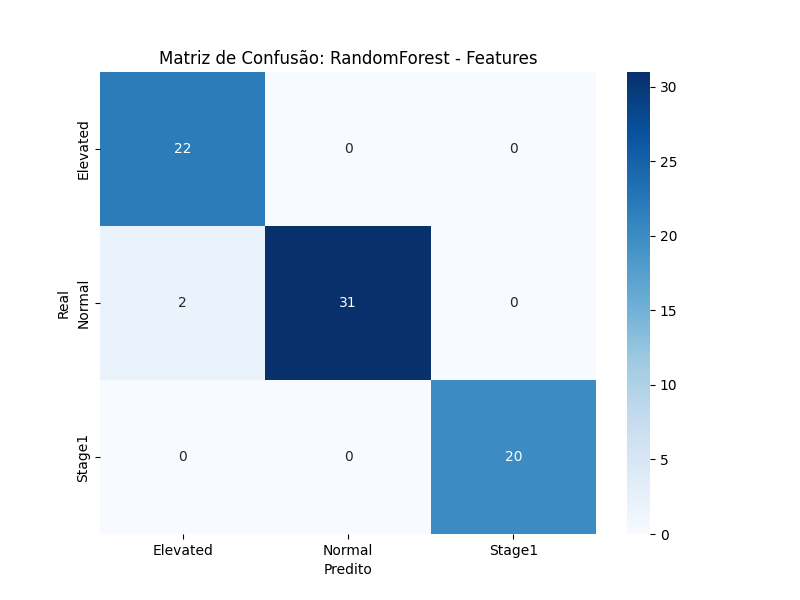

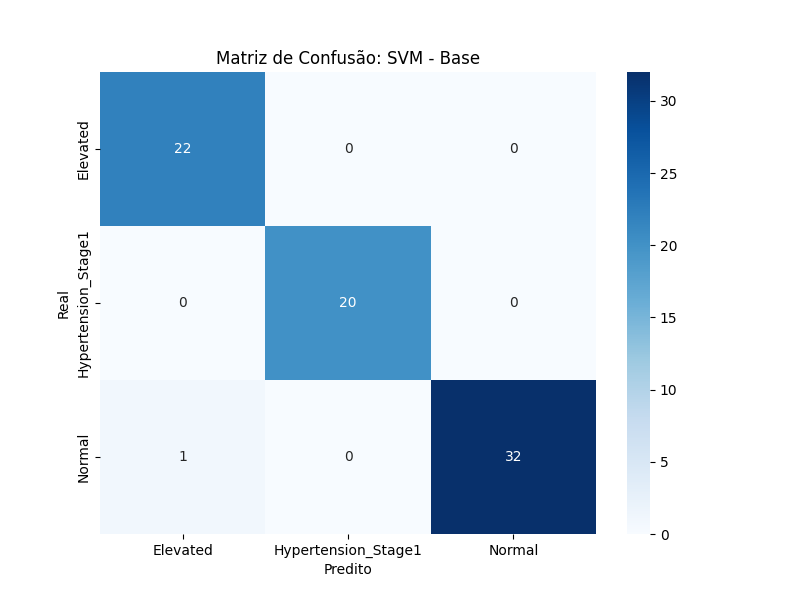

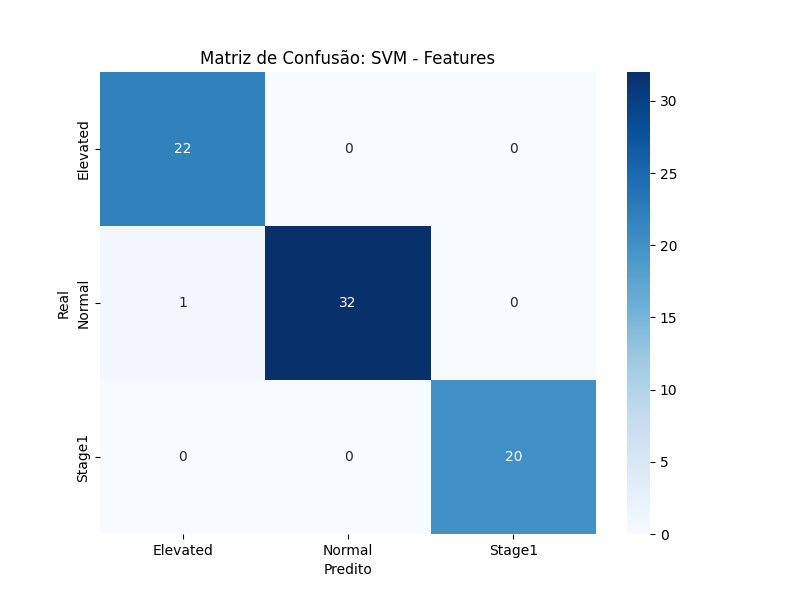

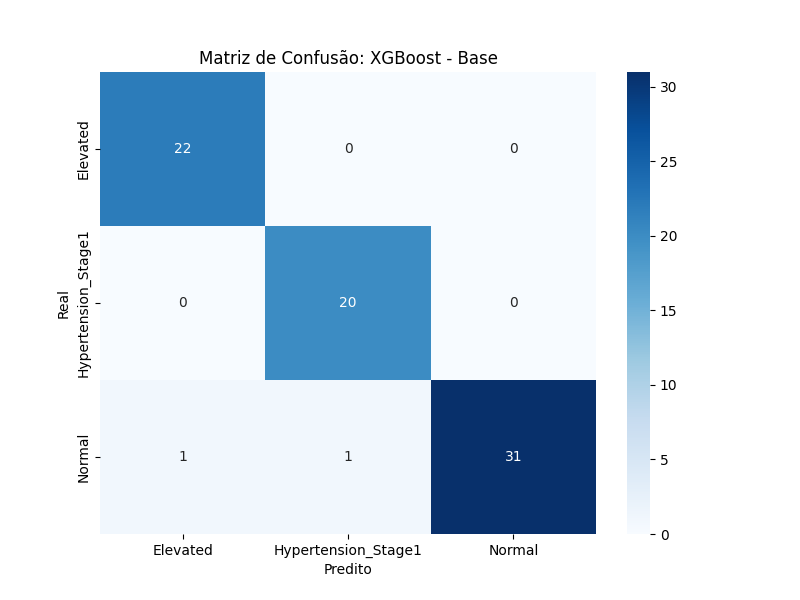

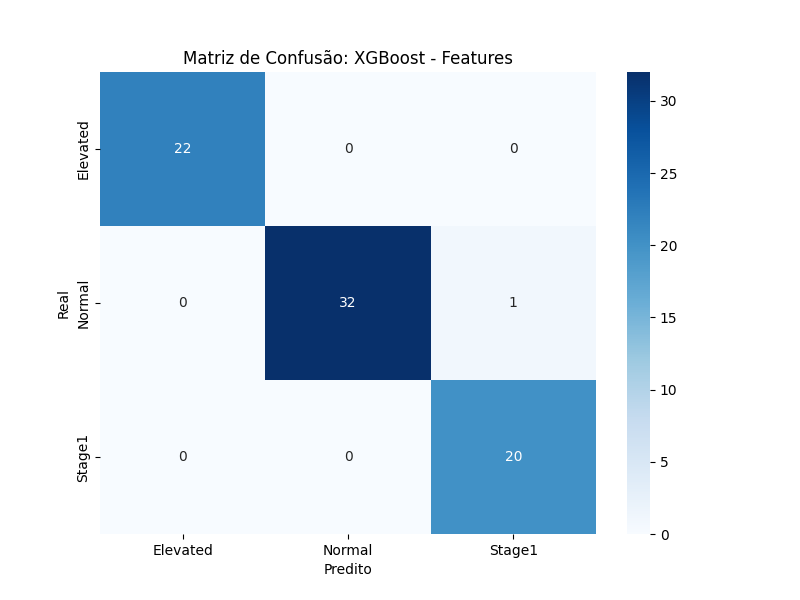

In [14]:
import glob
import os
from IPython.display import Image, display, HTML

# 1. Caminho onde as matrizes foram salvas
plot_save_path = os.path.join(output_path, 'plots')

# 2. Buscar todas as imagens que começam com 'matriz'
lista_matrizes = sorted(glob.glob(os.path.join(plot_save_path, "matriz_*.png")))

if not lista_matrizes:
    print("Nenhuma matriz de confusão encontrada na pasta de plots.")
else:
    print(f"Encontradas {len(lista_matrizes)} matrizes. Exibindo resultados:\n")

    for caminho_img in lista_matrizes:
        # Extrair o nome do modelo/dataset do nome do arquivo para o título
        nome_arquivo = os.path.basename(caminho_img).replace('matriz_', '').replace('.png', '')

        display(HTML(f"<h3>Modelo: {nome_arquivo}</h3>"))
        display(Image(filename=caminho_img))

### Feature Importance (Exclusivo do RandomForest e DecisionTree)

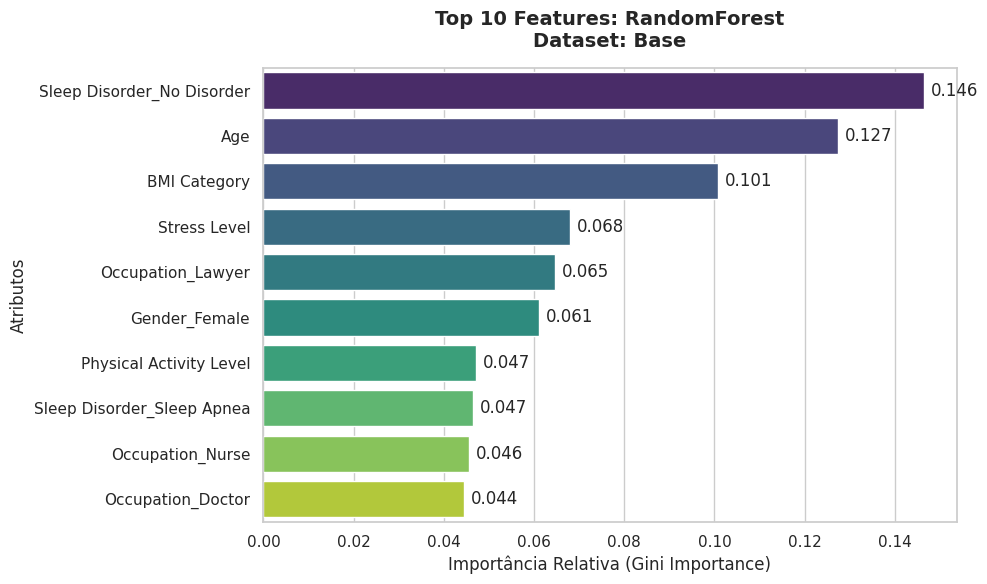

✅ Gráfico de importância para RandomForest (Base) salvo com sucesso.


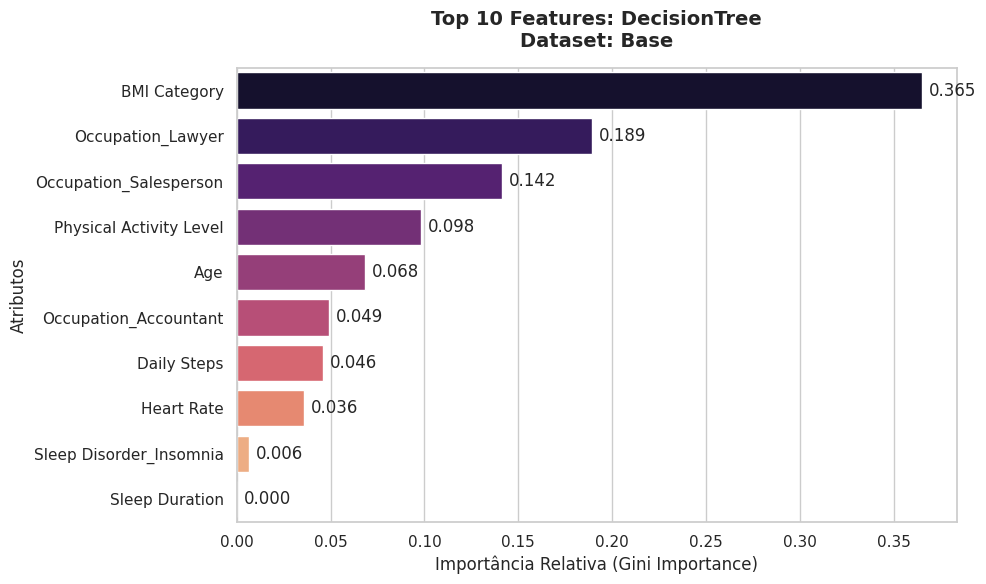

✅ Gráfico de importância para DecisionTree (Base) salvo com sucesso.


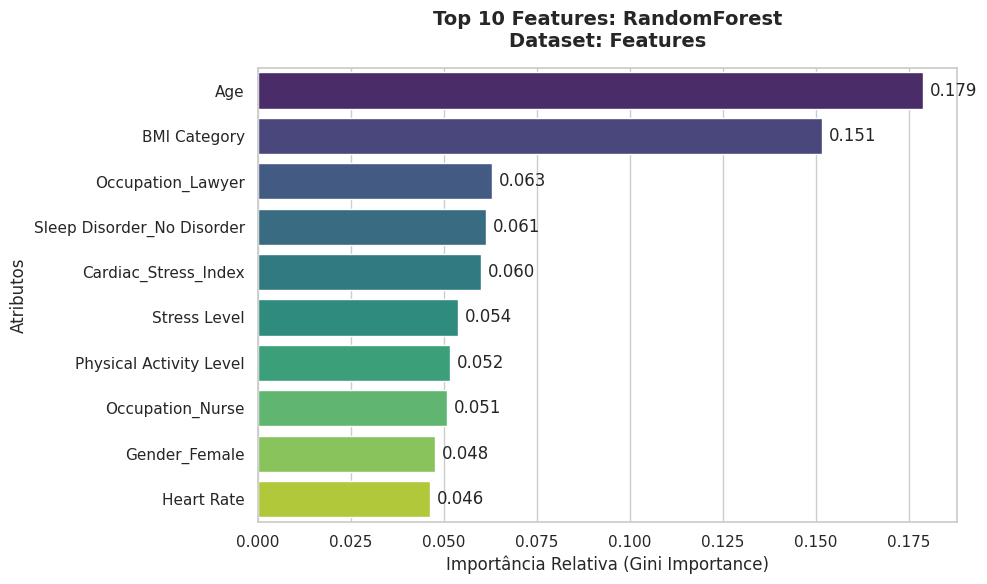

✅ Gráfico de importância para RandomForest (Features) salvo com sucesso.


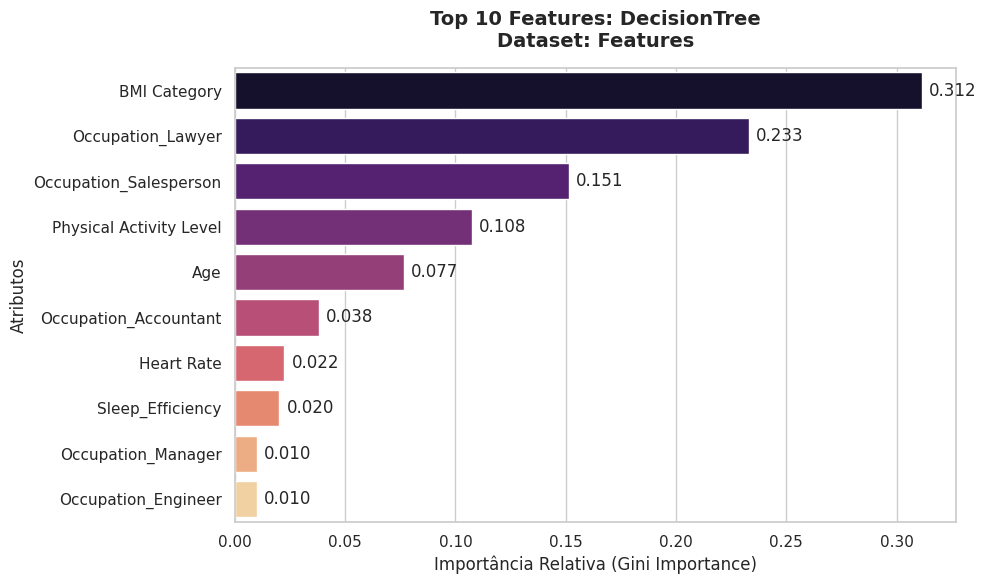

✅ Gráfico de importância para DecisionTree (Features) salvo com sucesso.


In [ ]:
# --- Célula: Visualização da Importância das Features ---
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

def gerar_graficos_importancia(results_list, model_save_path, output_path):
    """
    Carrega os modelos salvos e gera gráficos de importância das features
    para cada combinação de Modelo e Dataset.
    """
    # Configuração visual
    sns.set_theme(style="whitegrid")

    for res in results_list:
        model_name = res['Model']
        ds_name = res['Dataset']

        # Caminho do modelo salvo no Drive
        path_modelo = os.path.join(model_save_path, f"{model_name}_{ds_name}.pkl")

        if os.path.exists(path_modelo):
            # Carregar o pipeline completo (inclui preprocessor e classifier)
            pipeline = joblib.load(path_modelo)

            # 1. Recuperar nomes das colunas (considerando o One-Hot Encoding)
            # O get_feature_names_out() extrai os nomes gerados pelo ColumnTransformer
            preprocessor = pipeline.named_steps['preprocessor']
            feature_names = preprocessor.get_feature_names_out()

            # Limpar nomes (remover prefixos técnicos 'num__' e 'cat__')
            feature_names = [name.split('__')[-1] for name in feature_names]

            # 2. Extrair importâncias do classificador (RF ou DT)
            classifier = pipeline.named_steps['classifier']
            importances = classifier.feature_importances_

            # 3. Criar DataFrame para organizar o Top 10
            df_imp = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importances
            }).sort_values(by='Importance', ascending=False).head(10)

            # 4. Criação do Gráfico
            plt.figure(figsize=(10, 6))
            cores = 'viridis' if model_name == 'RandomForest' else 'magma'

            ax = sns.barplot(
                data=df_imp,
                x='Importance',
                y='Feature',
                palette=cores,
                hue='Feature',
                legend=False
            )

            # Estilização
            plt.title(f"Top 10 Features: {model_name}\nDataset: {ds_name}", fontsize=14, fontweight='bold', pad=15)
            plt.xlabel("Importância Relativa (Gini Importance)", fontsize=12)
            plt.ylabel("Atributos", fontsize=12)

            # Adicionar os valores numéricos nas pontas das barras para precisão
            for i in ax.containers:
                ax.bar_label(i, fmt='%.3f', padding=5)

            plt.tight_layout()

            # Salvar o gráfico no Drive
            nome_arquivo = f"feat_imp_{model_name}_{ds_name}.png"
            plt.savefig(os.path.join(output_path, nome_arquivo), dpi=300)
            plt.show()
            print(f"✅ Gráfico de importância para {model_name} ({ds_name}) salvo com sucesso.")
        else:
            print(f"⚠️ Modelo {model_name}_{ds_name}.pkl não encontrado no caminho especificado.")

# Execução automática
gerar_graficos_importancia(results_list, model_save_path, output_path)